In [ ]:
!pip install -qq numpyro;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from functools import partial

from jax import jit, vmap
import jax.numpy as jnp
from jax import random

import matplotlib.pyplot as plt
import time

In [ ]:
numpyro.set_host_device_count(4)

In [ ]:
key = random.PRNGKey(1)

In [ ]:
@partial(jit, static_argnums=(1,2))
def assumed_dgp(t1, batch_size=1, n_obs=100, key=None):
    return dist.Normal(t1, 1).sample(key=key, sample_shape=(batch_size, n_obs))

In [ ]:
@partial(jit, static_argnums=(1,2,3))
def true_dgp(t1, stdev_err=2.0, batch_size=1, n_obs=100,y=None):
    w = 0.8  # i.e. 20% of samples are contaminated
    std_devs = random.choice(key, jnp.array([1.0, stdev_err]), shape=(batch_size, n_obs), p=jnp.array([w, 1-w]))
    key, subkey = random.split(key)
    standard_y = dist.Normal(0, 1).sample(key, sample_shape=(batch_size, n_obs))
    y = (standard_y * std_devs) + t1
    
    return y

In [ ]:
@jit
def summ_stats(x):
    s0 = jnp.mean(x, axis=1)
    s1 = jnp.var(x, axis=1, ddof=1)  # ddof ->  divisor used in the calculation is N - ddof

    return jnp.hstack((s0, s1))

In [ ]:
@partial(jit, static_argnums=(1))
def simulation_wrapper(params, batch_size=1, key=None):
    x_sim = assumed_dgp(params, batch_size=batch_size, key=key)
    sim_sum = summ_stats(x_sim)
    return sim_sum

In [ ]:
true_param = jnp.array([1.0])

In [ ]:
n_obs = 100

In [ ]:
key, subkey = random.split(key)

In [ ]:
x_obs = jnp.array([1.0, 2.0])  # manually set observed data for testing

In [ ]:
prior = dist.Normal(jnp.array([0.0]), jnp.array([10.0]))

In [ ]:
!pip install -U flowjax --quiet;  # library used to train nsf flow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 9.3 MB/s eta 0:00:00


In [ ]:
from flowjax.flows import CouplingFlow
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import StandardNormal
from flowjax.train_utils import train_flow

ModuleNotFoundError: ignored

In [ ]:
from numpyro.distributions.util import validate_sample

In [ ]:
class FlowNumpyro(dist.Distribution):
    def __init__(self, flow=None, theta=None):
        self.flow = flow
        self.theta = theta
        super(FlowNumpyro, self).__init__()
        
    def sample(self, num_samples=1):
        return self.flow.sample(num_samples)

    @validate_sample
    def log_prob(self, value):
        ll = self.flow.log_prob(value, condition=self.theta)
        return ll

In [ ]:
def model(x_obs_standard, prior, density_estimator, laplace_var=None, standardisation_params=None, key=None):
    theta = numpyro.sample('theta', prior)
    theta_dims = len(standardisation_params['theta_mean'])
    laplace_mean = jnp.array([0.0, 0.0])

    if laplace_var is None:
        laplace_var = jnp.array([1.0, 1.0])
   
    # flow_sims = 100  # TODO: CHOSEN ABITRARILY 
    key, subkey = random.split(key)

    # if density_estimator is not None:  # TODO?
    theta_standard = numpyro.deterministic('theta_standard', (theta - standardisation_params['theta_mean']) / standardisation_params['theta_std'])
    #     samples = density_estimator.sample(subkey, condition=jnp.tile(theta_standard, flow_sims).reshape((-1, theta_dims)))
    #     flow_samples_std = numpyro.deterministic('flow_std', jnp.std(samples, axis=0))
    # else:
    #     flow_samples_std = numpyro.deterministic('flow_std', jnp.std(simulation_wrapper(theta, flow_sims, key=subkey), axis=0))  # TODO! BAD

    adj_params = numpyro.sample('adj_params', dist.Laplace(laplace_mean, laplace_var))
    x_adj = numpyro.deterministic('x_adj', x_obs_standard - adj_params)
    if density_estimator is not None:  # TODO?
        x_adj_sample = numpyro.sample('x_adj_sample', FlowNumpyro(density_estimator, theta=theta_standard), obs=x_adj)
    else:
        x_adj_sample = x_adj

    return x_adj_sample

In [ ]:
@jit
def generate_simulations(theta, key):
    x_sim = simulation_wrapper(theta, key=key) 
    return x_sim

generate_simulations_vmap = vmap(generate_simulations, in_axes=(0, 0))

In [ ]:
tic = time.time()

In [ ]:
num_rounds = 10
num_sims_per_round = 1000
thinning = 10
num_warmup = 1000
num_chains = 4
summary_dims = len(x_obs)
theta_dims = len(true_param)

x_sims_all = jnp.empty((0, summary_dims))
thetas_all = jnp.empty((0, theta_dims))

flow = None

init_params = {
    'theta': jnp.repeat(true_param, num_chains).reshape(num_chains, -1),
    'adj_params': jnp.repeat(jnp.zeros(summary_dims), num_chains).reshape(num_chains, -1)
    }

x_obs_standard = x_obs

standardisation_params = {
    'theta_mean': jnp.empty(theta_dims),
    'theta_std': jnp.empty(theta_dims),
    'x_sims_mean': jnp.empty(summary_dims),
    'x_sims_std': jnp.empty(summary_dims)
}

for i in range(num_rounds):
    nuts_kernel = NUTS(model, target_accept_prob=0.95)  # INCREASED FOR ROBUSTNESS
    mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=round((num_sims_per_round*thinning)/num_chains), thinning=thinning, num_chains=num_chains)
    key, subkey1, subkey2 = random.split(key, 3)
    laplace_var = 0.3 * jnp.abs(x_obs_standard)  # TODO: In testing...
    mcmc.run(subkey1, x_obs_standard, prior=prior, density_estimator=flow, 
             laplace_var=laplace_var,
             standardisation_params=standardisation_params, key=subkey2,
             init_params=init_params
             )

    # set init_params for next round MCMC to final round vals
    key, subkey = random.split(key)
    rand_idx = random.randint(subkey, (num_chains,), 0, num_sims_per_round)
    for k,_ in init_params.items():
        init_params[k] = mcmc.get_samples()[k][-rand_idx]

    print('init_params: ', init_params)

    thetas = mcmc.get_samples()['theta']

    sim_keys = random.split(key, len(thetas))
    x_sims = jnp.squeeze(generate_simulations_vmap(thetas, sim_keys))

    x_sims_all = jnp.append(x_sims_all, x_sims.reshape(-1, summary_dims), axis=0)
    thetas_all = jnp.append(thetas_all, thetas.reshape(-1, theta_dims), axis=0)

    # standardise simulated summaries
    standardisation_params['x_sims_mean'] = jnp.mean(x_sims_all, axis=0)
    standardisation_params['x_sims_std'] = jnp.std(x_sims_all, axis=0)
    x_sims_all_standardised = (x_sims_all - standardisation_params['x_sims_mean'] ) / standardisation_params['x_sims_std']
    x_obs_standard = (x_obs - standardisation_params['x_sims_mean']) / standardisation_params['x_sims_std']

    # standardise parameters
    standardisation_params['theta_mean'] = jnp.mean(thetas_all, axis=0)
    standardisation_params['theta_std'] = jnp.std(thetas_all, axis=0)    
    print('standardisation_params: ', standardisation_params)

    thetas_all_standardised = (thetas_all - standardisation_params['theta_mean']) / standardisation_params['theta_std']

    key, subkey = random.split(key)
    flow = CouplingFlow(
        key=subkey,
        base_dist=StandardNormal((2,)),
        transformer=RationalQuadraticSpline(knots=10, interval=5), # 10 spline segments over [-5, 5].  # TODO? Increase num segments?
        cond_dim=thetas_all_standardised.shape[1]
        )

    key, subkey = random.split(key)
    flow, losses = train_flow(subkey, flow, x_sims_all_standardised, thetas_all_standardised)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([[16.372608 ],
             [-2.812538 ],
             [-1.7563443],
             [ 3.34796  ]], dtype=float32), 'adj_params': DeviceArray([[-0.46632677,  1.4241779 ],
             [-0.22616644, -0.13670966],
             [-0.2014463 ,  0.902544  ],
             [ 0.08325732,  0.38730982]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.21671812], dtype=float32), 'theta_std': DeviceArray([9.890726], dtype=float32), 'x_sims_mean': DeviceArray([-0.21566172,  1.0034475 ], dtype=float32), 'x_sims_std': DeviceArray([9.889186  , 0.14174545], dtype=float32)}


100%|██████████| 50/50 [00:22<00:00,  2.25it/s, train=-.83, val=0]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([[0.74125   ],
             [0.30203113],
             [1.4248458 ],
             [0.7820929 ]], dtype=float32), 'adj_params': DeviceArray([[ 5.5392990e-03,  4.8099079e+00],
             [ 8.7119155e-02,  7.0329742e+00],
             [-6.1918020e-02,  4.8710690e+00],
             [ 1.5182337e-02,  5.6100469e+00]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([0.39833602], dtype=float32), 'theta_std': DeviceArray([7.0413566], dtype=float32), 'x_sims_mean': DeviceArray([0.40058845, 1.003928  ], dtype=float32), 'x_sims_std': DeviceArray([7.040873  , 0.14194402], dtype=float32)}


100%|██████████| 50/50 [00:15<00:00,  3.17it/s, train=-.888, val=0]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([[0.9216735 ],
             [1.4898226 ],
             [0.6483143 ],
             [0.41733292]], dtype=float32), 'adj_params': DeviceArray([[-0.01793867,  7.03803   ],
             [-0.07139461,  5.789654  ],
             [ 0.0123276 ,  5.7160397 ],
             [ 0.08443944,  6.6394706 ]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([0.61242217], dtype=float32), 'theta_std': DeviceArray([5.7607303], dtype=float32), 'x_sims_mean': DeviceArray([0.6131416, 1.0042274], dtype=float32), 'x_sims_std': DeviceArray([5.7604046 , 0.14143802], dtype=float32)}


 94%|█████████▍| 47/50 [00:20<00:01,  2.25it/s, train=-.974, val=-.803 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([[0.9772465],
             [1.1661131],
             [1.086475 ],
             [1.0251307]], dtype=float32), 'adj_params': DeviceArray([[-3.0545953e-03,  6.3252649e+00],
             [-9.5176240e-03,  5.7992063e+00],
             [ 5.5176970e-03,  6.7497716e+00],
             [-1.1648048e-02,  6.2825413e+00]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([0.7002839], dtype=float32), 'theta_std': DeviceArray([4.9925895], dtype=float32), 'x_sims_mean': DeviceArray([0.700816 , 1.0035013], dtype=float32), 'x_sims_std': DeviceArray([4.992532  , 0.14067629], dtype=float32)}


100%|██████████| 50/50 [00:27<00:00,  1.79it/s, train=-.873, val=-.718]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([[0.98423815],
             [1.06478   ],
             [0.75141096],
             [1.1595203 ]], dtype=float32), 'adj_params': DeviceArray([[-3.3427710e-03,  7.1732793e+00],
             [-1.9106621e-02,  6.2062531e+00],
             [ 2.2549119e-02,  7.2353177e+00],
             [-9.2216013e-03,  6.5137920e+00]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([0.7569307], dtype=float32), 'theta_std': DeviceArray([4.4678397], dtype=float32), 'x_sims_mean': DeviceArray([0.7572573, 1.0031717], dtype=float32), 'x_sims_std': DeviceArray([4.468065 , 0.1417362], dtype=float32)}


 42%|████▏     | 21/50 [00:18<00:26,  1.11it/s, train=-.618, val=-.615 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([[0.9273568 ],
             [0.95960563],
             [0.9431916 ],
             [0.66481936]], dtype=float32), 'adj_params': DeviceArray([[6.7126593e-03, 6.9310627e+00],
             [1.3885185e-02, 5.6461897e+00],
             [1.8084824e-02, 6.2814522e+00],
             [5.7948660e-02, 6.7727814e+00]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([0.79579556], dtype=float32), 'theta_std': DeviceArray([4.082441], dtype=float32), 'x_sims_mean': DeviceArray([0.796483 , 1.0027126], dtype=float32), 'x_sims_std': DeviceArray([4.0828776 , 0.14244737], dtype=float32)}


 62%|██████▏   | 31/50 [00:22<00:13,  1.37it/s, train=-.572, val=-.621 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([[1.0976917 ],
             [1.0267367 ],
             [0.84835434],
             [1.0173516 ]], dtype=float32), 'adj_params': DeviceArray([[-2.3023514e-02,  6.1812053e+00],
             [ 3.7707263e-03,  5.8110542e+00],
             [ 1.6127603e-02,  7.1680126e+00],
             [-6.4090891e-05,  6.4944015e+00]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([0.826934], dtype=float32), 'theta_std': DeviceArray([3.7809036], dtype=float32), 'x_sims_mean': DeviceArray([0.8273043, 1.002204 ], dtype=float32), 'x_sims_std': DeviceArray([3.7814665 , 0.14268836], dtype=float32)}


 68%|██████▊   | 34/50 [00:24<00:11,  1.36it/s, train=-.541, val=-.174 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([[ 1.0889125 ],
             [ 0.792838  ],
             [ 0.9588082 ],
             [-0.74494344]], dtype=float32), 'adj_params': DeviceArray([[-1.1872970e-02,  6.5556431e+00],
             [ 7.0212055e-03,  5.6723971e+00],
             [ 1.8488724e-03,  6.6527104e+00],
             [ 1.4219613e-02,  2.0273869e+00]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([0.78661245], dtype=float32), 'theta_std': DeviceArray([3.5525603], dtype=float32), 'x_sims_mean': DeviceArray([0.78621775, 1.0019072 ], dtype=float32), 'x_sims_std': DeviceArray([3.5533183 , 0.14308964], dtype=float32)}


 38%|███▊      | 19/50 [00:20<00:34,  1.10s/it, train=-.408, val=-.263 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([[0.9775666 ],
             [0.95736855],
             [1.0722815 ],
             [0.749388  ]], dtype=float32), 'adj_params': DeviceArray([[-1.8470669e-03,  5.5030575e+00],
             [ 7.6993043e-03,  7.4262915e+00],
             [ 2.8858770e-02,  8.1980953e+00],
             [ 2.8986724e-03,  6.7565842e+00]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([0.8107318], dtype=float32), 'theta_std': DeviceArray([3.3504992], dtype=float32), 'x_sims_mean': DeviceArray([0.81092566, 1.0018715 ], dtype=float32), 'x_sims_std': DeviceArray([3.3513873 , 0.14357615], dtype=float32)}


 42%|████▏     | 21/50 [00:22<00:31,  1.07s/it, train=-.371, val=-.408 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([[0.9357256],
             [1.0927014],
             [0.7360665],
             [0.8774152]], dtype=float32), 'adj_params': DeviceArray([[-4.1242871e-02,  5.0713301e+00],
             [-9.7921595e-04,  7.0730457e+00],
             [-6.2242878e-04,  7.4974623e+00],
             [ 2.1093952e-02,  6.5750852e+00]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([0.8274139], dtype=float32), 'theta_std': DeviceArray([3.1792881], dtype=float32), 'x_sims_mean': DeviceArray([0.82759297, 1.0017815 ], dtype=float32), 'x_sims_std': DeviceArray([3.1803055 , 0.14322507], dtype=float32)}


 58%|█████▊    | 29/50 [00:27<00:19,  1.07it/s, train=-.296, val=-.327 (Max patience reached)]


In [ ]:
x_obs_standard

DeviceArray([0.05421084, 6.9695797 ], dtype=float32)

In [ ]:
thetas

DeviceArray([[1.231332  ],
             [0.7280242 ],
             [0.75356656],
             [0.82815486],
             [0.8332826 ],
             [0.8765515 ],
             [1.0296744 ],
             [0.7447034 ],
             [0.8369828 ],
             [1.162586  ],
             [1.1265049 ],
             [0.8302947 ],
             [0.93631256],
             [0.7984697 ],
             [0.75560623],
             [0.93319637],
             [0.854008  ],
             [0.91904426],
             [1.1225004 ],
             [1.0733124 ],
             [0.7268471 ],
             [1.128863  ],
             [0.70659   ],
             [0.9850244 ],
             [1.0664208 ],
             [0.7478165 ],
             [1.0381733 ],
             [1.0283847 ],
             [0.89332145],
             [1.0828792 ],
             [0.8605333 ],
             [1.2129242 ],
             [1.1468104 ],
             [1.0813596 ],
             [1.1479511 ],
             [0.9604853 ],
             [1.0690234 ],
 

In [ ]:
init_params

{'theta': DeviceArray([[0.9357256],
              [1.0927014],
              [0.7360665],
              [0.8774152]], dtype=float32),
 'adj_params': DeviceArray([[-4.1242871e-02,  5.0713301e+00],
              [-9.7921595e-04,  7.0730457e+00],
              [-6.2242878e-04,  7.4974623e+00],
              [ 2.1093952e-02,  6.5750852e+00]], dtype=float32)}

In [ ]:
standardisation_params

{'theta_mean': DeviceArray([0.8274139], dtype=float32),
 'theta_std': DeviceArray([3.1792881], dtype=float32),
 'x_sims_mean': DeviceArray([0.82759297, 1.0017815 ], dtype=float32),
 'x_sims_std': DeviceArray([3.1803055 , 0.14322507], dtype=float32)}

In [ ]:
mcmc.get_samples()['x_adj'][-1]

DeviceArray([0.04246049, 0.16413927], dtype=float32)

In [ ]:
# SAMPLE FINAL POSTERIOR
nuts_kernel = NUTS(model, target_accept_prob=0.95)  # INCREASED FOR ROBUSTNESS
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=25000, thinning=1, num_chains=4)  # TODO: MAKING NUMBERS UP
key, subkey1, subkey2 = random.split(key, 3)
laplace_var = 0.3 * jnp.abs(x_obs_standard)
mcmc.run(subkey1, x_obs_standard, prior, density_estimator=flow, standardisation_params=standardisation_params,
         laplace_var=laplace_var,
         init_params=init_params,
         key=subkey2)

  0%|          | 0/26000 [00:00<?, ?it/s]

  0%|          | 0/26000 [00:00<?, ?it/s]

  0%|          | 0/26000 [00:00<?, ?it/s]

  0%|          | 0/26000 [00:00<?, ?it/s]

In [ ]:
toc = time.time()

In [ ]:
print('time: ', toc - tic)

time:  2246.6381952762604


In [ ]:
# numpyro.render_model(model, model_args=(x_obs, prior, flow, prior, subkey), render_distributions=True)

In [ ]:
mcmc.print_summary()  


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]      0.00      0.02      0.00     -0.04      0.04  34768.65      1.00
adj_params[1]      6.45      1.07      6.50      4.67      8.24  34527.45      1.00
     theta[0]      1.00      0.17      1.00      0.79      1.22   6890.20      1.00

Number of divergences: 0


In [ ]:
import arviz as az
# az.style.use("arviz-doc")

In [ ]:
inference_data = az.from_numpyro(mcmc)

In [ ]:
inference_data['posterior']

<xarray.Dataset>
Dimensions:               (chain: 4, draw: 25000, adj_params_dim_0: 2,
                           theta_dim_0: 1, theta_standard_dim_0: 1,
                           x_adj_dim_0: 2)
Coordinates:
  * chain                 (chain) int64 0 1 2 3
  * draw                  (draw) int64 0 1 2 3 4 ... 24996 24997 24998 24999
  * adj_params_dim_0      (adj_params_dim_0) int64 0 1
  * theta_dim_0           (theta_dim_0) int64 0
  * theta_standard_dim_0  (theta_standard_dim_0) int64 0
  * x_adj_dim_0           (x_adj_dim_0) int64 0 1
Data variables:
    adj_params            (chain, draw, adj_params_dim_0) float32 0.01121 ......
    theta                 (chain, draw, theta_dim_0) float32 0.8925 ... 1.276
    theta_standard        (chain, draw, theta_standard_dim_0) float32 0.02049...
    x_adj                 (chain, draw, x_adj_dim_0) float32 0.043 ... 1.031
Attributes:
    created_at:                 2023-01-18T05:27:20.263249
    arviz_version:              0.12.1
    inference_library:          numpyro
    inference_library_version:  0.10.1

In [ ]:
import pickle as pkl

with open('rsnl_contaminated_normal_thetas.pkl', 'wb') as f: pkl.dump(inference_data.posterior.theta, f)

with open('rsnl_contaminated_normal_adj_params.pkl', 'wb') as f: pkl.dump(inference_data.posterior.adj_params, f)

In [ ]:
# assuming have SNL data in colab ... lazy
with open('snl_contaminated_normal_theta.pkl', 'rb') as f:
    theta_snl = pkl.load(f)

In [ ]:
folder_name = "vis/rsnl_contaminated_normal_stdev_err_" #+ str(stdev_err)

In [ ]:
import os
isExist = os.path.exists(folder_name)
if not isExist:
    os.makedirs(folder_name)

In [ ]:
theta_plot = {}
var_name_map = {}
reference_values = {}

for i in range(theta_dims):
    key_name = 'theta' + str(i+1)
    theta_plot[key_name] = inference_data.posterior.theta.values.flatten()
    var_name_map[key_name] = fr'$\theta$'
for i in range(summary_dims):
    key_name = 'adj param' + str(i+1)
    theta_plot[key_name] = inference_data.posterior.adj_params.values[:, :, i].flatten()
    var_name_map[key_name] = fr'$\gamma_{i+1}$'

# for ii, k in enumerate(theta_plot):
    # if 'theta' in var_name_map[k]:
    # var_name_map[k] = fr'$\{k[:-1]}_{k[-1]}$'
    #     reference_values[var_name_map[k]] = true_params[ii]  # why does ref_vals match labels and not data? ah well

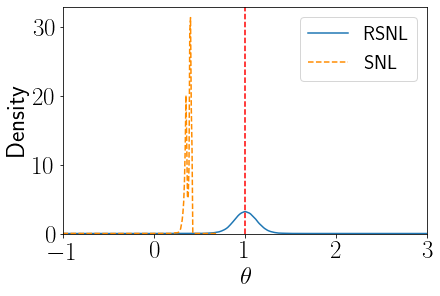

In [ ]:
import matplotlib.colors as mcolors

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 25})
plt.rcParams['xtick.labelsize'] = 25
az.plot_dist(inference_data.posterior.theta,
             label='RSNL'
            #  plot_kwargs={'plot_kwargs': }
             )
az.plot_dist(theta_snl.values.flatten(),
             color=mcolors.CSS4_COLORS['darkorange'],
             plot_kwargs={'linestyle': 'dashed'},
             label='SNL'
             )
plt.xlabel(r"$\theta$", fontsize=25)
plt.xlim([-1, 3])
plt.ylim(bottom=0)
plt.legend(fontsize=20)
plt.ylabel("Density", fontsize=25)
plt.axvline(x=1, color='red', linestyle='dashed')
# plt.title("$b_0 = 0.01$")
plt.savefig('contaminated_normal_posterior.pdf')

In [ ]:
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super;
!pip install -U latex --quiet;

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-15).
dvipng is already the newest version (1.15-1.1).
texlive is already the newest version (2019.20200218-1).
texlive-fonts-recommended is already the newest version (2019.20200218-1).
texlive-latex-extra is already the newest version (2019.202000218-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
labeller = az.labels.MapLabeller(var_name_map=var_name_map)

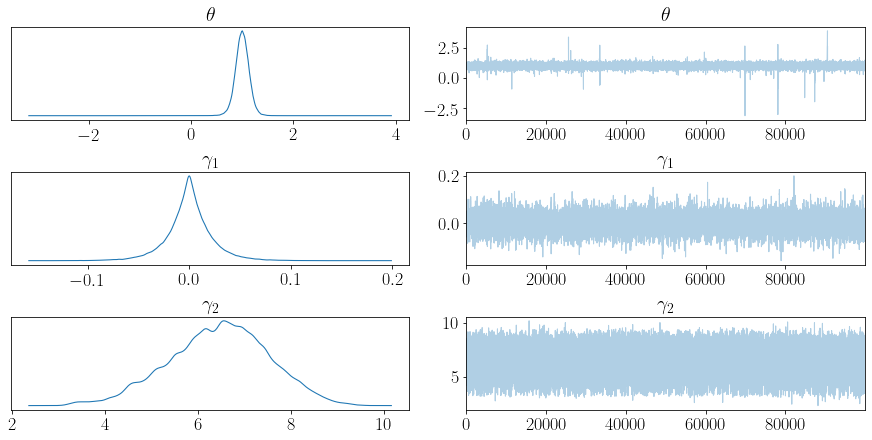

In [ ]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['text.usetex'] = True

axes = az.plot_trace(theta_plot,
              compact=False,
              labeller=labeller,
              plot_kwargs={'textsize': 18},
              );

for ii, axes_ii in enumerate(axes):
    for jj, axes_jj in enumerate(axes_ii):
        axes_jj.title.set_fontsize(20)

plt.savefig(f"{folder_name}_traceplots.pdf")
plt.show()

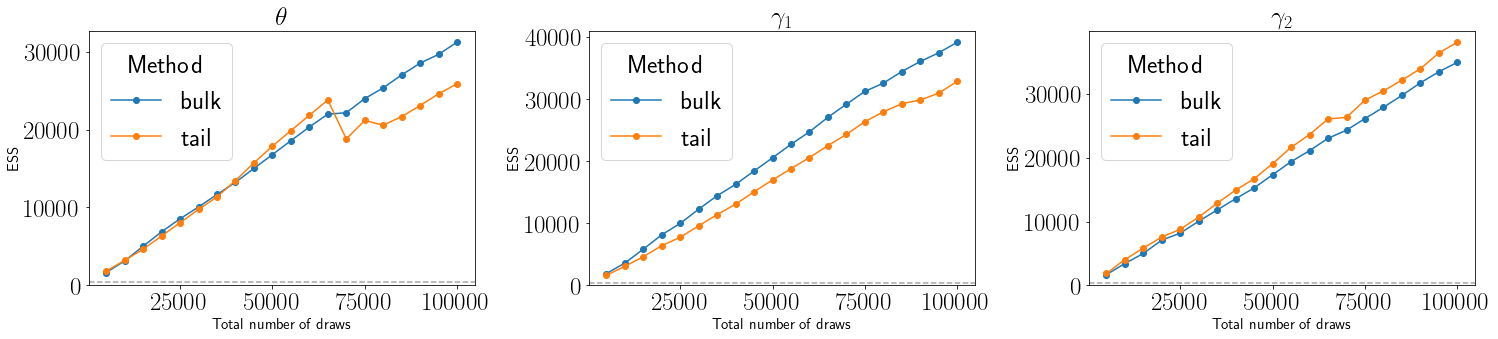

In [ ]:
plt.rcParams['text.usetex'] = True

axes = az.plot_ess(theta_plot, kind="evolution", labeller=labeller);
for ii, axes_ii in enumerate(axes):
    # for jj, axes_jj in enumerate(axes_ii):
    axes_ii.title.set_fontsize(26)
plt.savefig(f"{folder_name}_ess_plots.pdf")
plt.show()

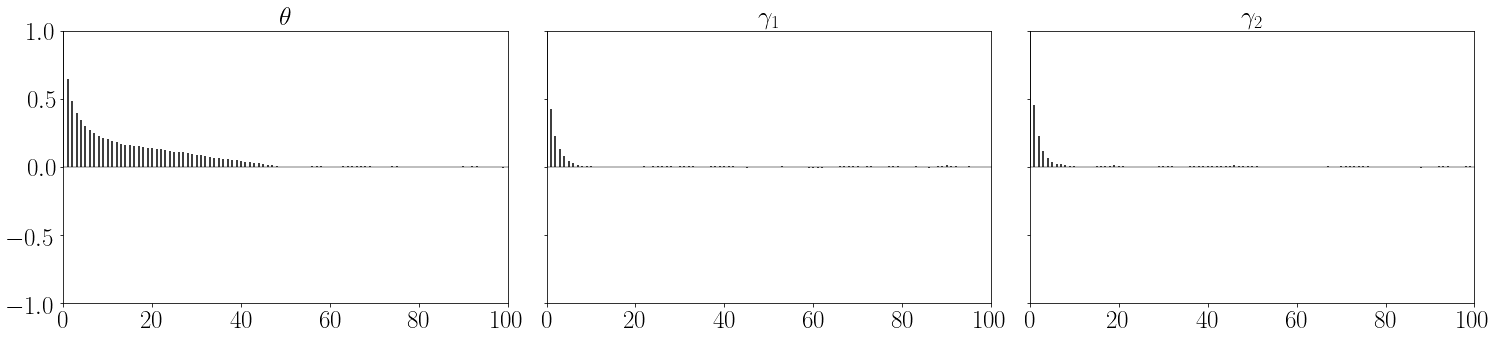

In [ ]:
plt.rcParams['text.usetex'] = True

axes = az.plot_autocorr(theta_plot, combined=True, labeller=labeller);
for ii, axes_ii in enumerate(axes):
    # for jj, axes_jj in enumerate(axes_ii):
    axes_ii.title.set_fontsize(26)

plt.savefig(f"{folder_name}_autocorr.pdf")


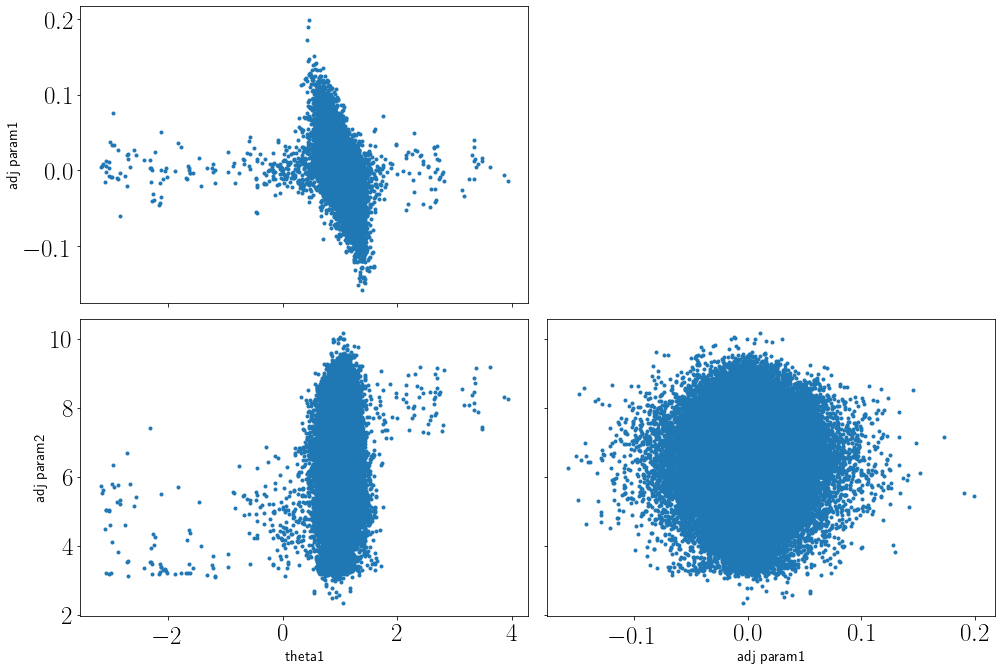

In [ ]:
az.plot_pair(theta_plot)
plt.savefig(f"{folder_name}_pair.png")


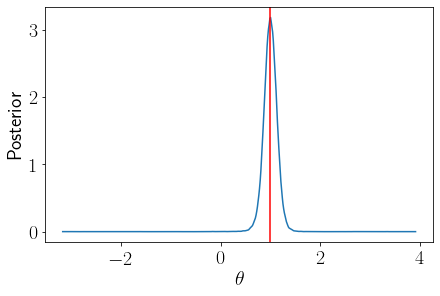

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
az.plot_dist(inference_data.posterior.theta,
            #  plot_kwargs={'plot_kwargs': }
             )
plt.xlabel(r"$\theta$", fontsize=20)
# plt.xlim([-1, 1])

plt.ylabel("Posterior", fontsize=20)
plt.axvline(x=1, color='red')
plt.savefig("rsnl_contaminated_normal_theta_posterior.pdf")
# plt.title("$b_0 = 0.01$")

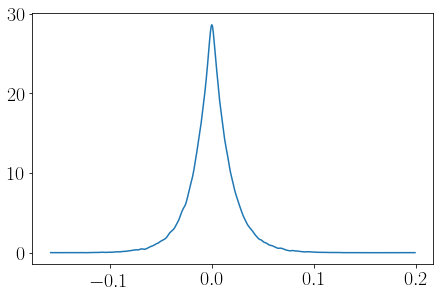

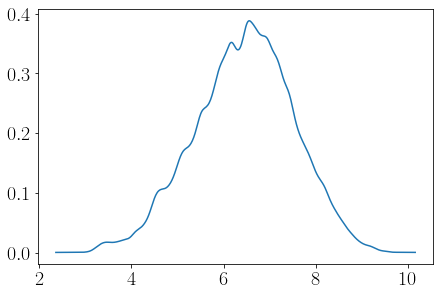

In [ ]:
for i in range(summary_dims):
    az.plot_dist(inference_data.posterior.adj_params[:, :, i].values.flatten())
    plt.savefig(f"rsnl_contaminated_normal_theta_adj_params{i}.pdf")
    plt.show()


In [ ]:
def model_no_adj(x_obs, prior, density_estimator=None):  #, density_estimator):
    theta = numpyro.sample('theta', prior)

    if density_estimator is not None:
        x_adj_sample = numpyro.sample('x_adj_sample', FlowNumpyro(density_estimator, x_obs, theta), obs=x_obs)
    else:
        x_adj_sample = x_obs


    return x_adj_sample

In [ ]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]      0.00      0.02      0.00     -0.04      0.04  34768.65      1.00
adj_params[1]      6.45      1.07      6.50      4.67      8.24  34527.45      1.00
     theta[0]      1.00      0.17      1.00      0.79      1.22   6890.20      1.00

Number of divergences: 0


In [ ]:
 laplace_mean = jnp.zeros(2)
 laplace_var = 0.3 * jnp.abs(x_obs_standard)
 key, subkey = random.split(key)

 prior_samples = dist.Laplace(laplace_mean, laplace_var).sample(subkey, (10000,))

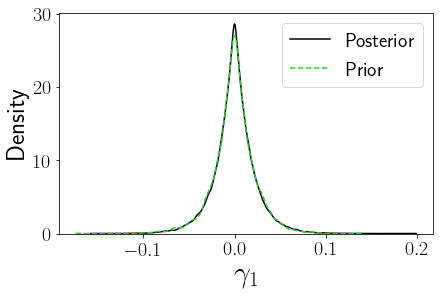

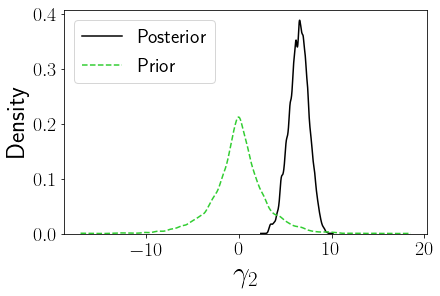

In [ ]:
import matplotlib.colors as mcolors

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 25})

for i in range(2):  # lazy
    az.plot_dist(inference_data.posterior.adj_params[:, :, i].values.flatten(),
                label='Posterior',
                 color='black')
    az.plot_dist(prior_samples[:, i], 
                 color=mcolors.CSS4_COLORS['limegreen'],
                 plot_kwargs={'linestyle': 'dashed'},
                 label='Prior')
    plt.xlabel(rf"$\gamma_{i+1}$", fontsize=30)
    plt.ylabel("Density", fontsize=25)
    plt.ylim(bottom=0)
    plt.legend(fontsize=20)
    # plt.title("$b_0 = 0.01$")
    plt.savefig(f'contaminated_normal_adj_param{i+1}.pdf')
    plt.show()